# Research of apartments for sale announcements

We have at our disposal the data of Yandex.Real Estate - an archive of several years' worth of apartments for sale in St. Petersburg and nearby settlements. We need to learn how to determine the market value of real estate objects. My task is to set the parameters. This will help to build an automated system: it will track anomalies and fraudulent activity. 

Two types of data are available for each apartment for sale. The first is entered by the user, the second is automatically obtained on the basis of map data. For example, the distance to the center, the airport, the nearest park and body of water. 



#### Step 1. Open the data file and examine the general information. 

In [64]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
print(data.info())
print(data.shape)
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

The original table has 22 columns and 23699 rows. 3 columns in int format, 3 in object format, 14 columns in float format and 2 in bool format

### Step 2: Preprocessing data

In [65]:
print(data.isnull().sum())
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(False)
data['floors_total'] = data['floors_total'].fillna(0)
data.loc[(data.loc[:, 'studio'] == 1) | (data.loc[:, 'open_plan'] == 1), 'kitchen_area'] = data['kitchen_area'].fillna(0)

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


There are 14 columns in the overall table that have at least one missing value. However, not all tables make sense to change these values to zero or other indicators, as it is not always relevant. Most likely, when you fill the announcement in places where you were not sure of the data was placed its omission. Delete such ads is incorrect. However, there are exceptions: 
.balcony column, where you can assume that skipping a value means that there is no balcony in the room. Here you can change it to 0. .is_apartment column, where the missing value means that the room is not an apartment. 
. the column floors_total, where the value skipped means a basement or a cellar. The substitution to 0 takes place here. 
.kithen_area column, where you can assume that in apartments with an open floor plan and 'studio' format, the omission of this column means that the kitchen area is zero.

In [66]:
print(data.info())
data['balcony'] = data['balcony'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23699 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21637 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

Using the info() method, we have seen the types of columns that do not match their definitions: .the balcony column can only take integer values, so we convert it to int. .the floors_total column cannot be fractional, so we convert it to int. .the is_apartment column can only take two values: whether the room is an apartment or not, which is a boolean data type (bool) .the first_day_exposition column is a time column, so we convert it to datetime format

In [67]:
print(data.duplicated().sum())

0


No duplicates have been found in the table.

### Step 3. Count and add to the table

In [68]:
data['price_per_square_meter'] = (data['last_price'] / data['total_area']).apply(lambda x: "{0:.8}".format(x))
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
def floor_category(row):
     if row['floor'] == 1:
        return 'первый'
     elif row['floor'] == row['floors_total']:
        return 'последний'
     else:
        return 'другой'
data['floor_category'] = data.apply(floor_category,axis=1)
data['attitude_living_total_area'] = (data['living_area'] / data['total_area']).apply(lambda x: "{0:.2%}".format(x))
data['attitude_kitchen_total_area'] = (data['kitchen_area'] / data['total_area']).apply(lambda x: "{0:.2%}".format(x))
print(data.head(5))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1             NaN            11         18.6      1         False  ...   
2             NaN             5         34.3      4         False  ...   
3             NaN            14          NaN      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   ponds_around3000  ponds_nearest  days_exposition  price_per_square_meter  \
0               2.0          755.0              N

1.To calculate the cost per square meter, create a new column price_per_square_meter, where we divide the price of the apartment (last_price) by the area of the apartment (total_area).
2.Let's add the day of the week to the new column weekday.
3.Add the month number in the new month column.
4.Add the year number in the new year column.
5. Categorize the floors for further work ("basement", "first", "last", "others"). To do this, create a column floor_category.
6. Let's find the ratio of the living area to the total area. Let's create a column attitude_living_total_area
7.Let's find the ratio of the kitchen area to the total area. Create the attitude_kitchen_total_area column

### Step 4. Perform exploratory data analysis and follow the instructions:

In [69]:
import matplotlib.pyplot as plt
print(data.describe())

       total_images    last_price    total_area         rooms  ceiling_height  \
count  23699.000000  2.369900e+04  23699.000000  23699.000000    14504.000000   
mean       9.858475  6.541549e+06     60.348651      2.070636        2.771499   
std        5.682529  1.088701e+07     35.654083      1.078405        1.261056   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.520000   
50%        9.000000  4.650000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.800000e+06     69.900000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23699.000000  21796.000000  23699.000000  21637.000000  23699.000000   
mean      10.635090     34.457852      5.892358     10.464290      0.591080   
std        6.616396     22.030445

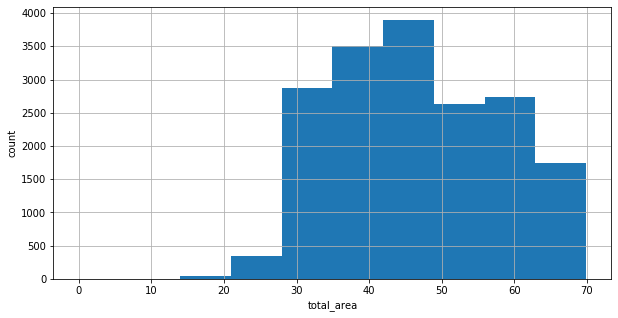

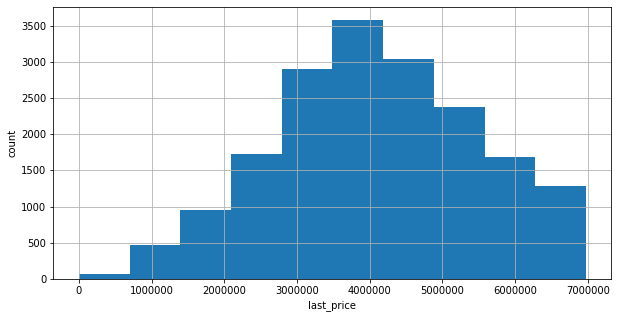

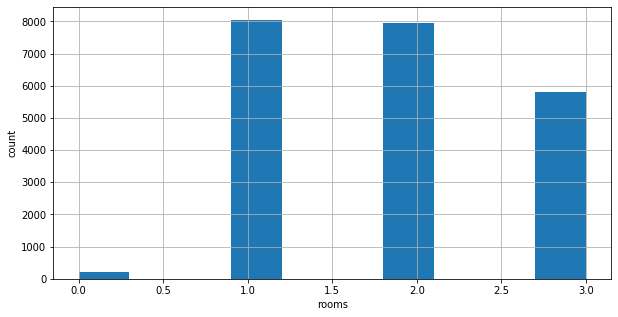

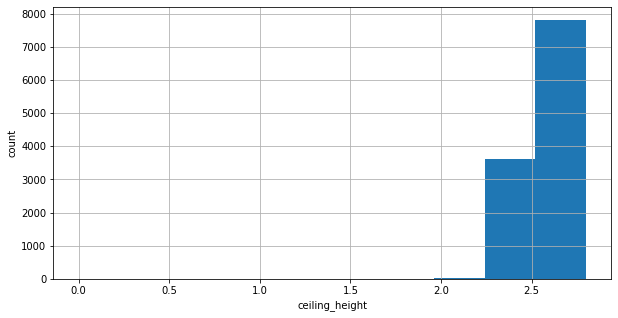

In [90]:
# create a dictionary of the columns we are interested in to further build the loop
selective_columns = [{'title':'total_area', "min":0, "max":69.9},
                     {'title':'last_price', "min":0, "max":6975000},
                     {'title':'rooms', "min":0, "max":3},
                     {'title':'ceiling_height', "min":0, "max":2.8}]
# create a function to further iterate the dictionary
def print_hist(df, col_title, col_min, col_max):
    fig, ax = plt.subplots()
    df.hist(bins=10, range=(col_min, col_max), figsize=(10,5))
    ax.set_xlabel(col_title)
    ax.set_ylabel("count")
    plt.show()
    
for col in selective_columns:
    col_title = col["title"]
    col_min = col["min"]
    col_max = col["max"]
    print_hist(data[col_title], col_title, col_min, col_max)
      

1.By constructing a histogram for the total area of the apartment, and excluding the "tail" with the knock-out values (including only the first 75% of all data), we see a normal distribution with a deviation to the left, which is associated with the fact that there are unspecified values. So the peak total area ranges from 42 to 49 square meters. 
2.By constructing a histogram for the cost of the apartment, and eliminating the "tail" of the knock-out values (including only the first 75% of all data), we see a normal distribution with a deviation to the left, which is associated with the fact that there are unspecified values. Thus, the peak value is 4650000 rubles per apartment.
3.5 Having plotted the histogram for height of ceilings, and having excluded "tails" with knocked out values (by including only the first 75% of all data), we see the peak ranging from 2.55 to 2.65 meters
4.Having plotted the histogram for the number of rooms and having excluded "tails" with outliers (by including only the first 75% of all data) we see that one-room apartments are most often represented, with two-room apartments being slightly inferior

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


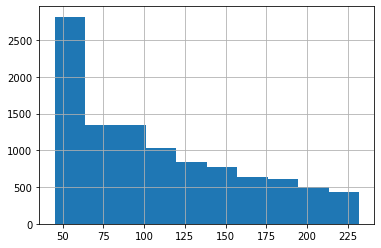

In [13]:
print(data['days_exposition'].describe())
data['days_exposition'].hist(bins=10,range=(45,232))

By examining the data on the length of time apartments have been sold (using the describe() method), we see that the average value is 180 days and the median value is 95 days. On average about three months to sell an apartment is a good indicator. Two months is already a fast transaction; less than a month and a half is very fast. In contrast, more than seven months is already unusually long to sell an apartment 

In [14]:
print(data.describe())
# using the describe() method, we see the maximum values in some columns that are anomalous for this table

       total_images    last_price    total_area         rooms  ceiling_height  \
count  23699.000000  2.369900e+04  23699.000000  23699.000000    14504.000000   
mean       9.858475  6.541549e+06     60.348651      2.070636        2.771499   
std        5.682529  1.088701e+07     35.654083      1.078405        1.261056   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.520000   
50%        9.000000  4.650000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.800000e+06     69.900000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23699.000000  21796.000000  23699.000000  21637.000000  23699.000000   
mean      10.635090     34.457852      5.892358     10.464290      0.591080   
std        6.616396     22.030445

In [15]:
print(data['ceiling_height'].sort_values(ascending=False))
data = data.query("(ceiling_height<=5 and ceiling_height>=2) or (ceiling_height.isna())")
data = data.query("rooms <=6")


22869    100.0
3148      32.0
22336     32.0
21377     27.5
10773     27.0
         ...  
23687      NaN
23690      NaN
23692      NaN
23695      NaN
23696      NaN
Name: ceiling_height, Length: 23699, dtype: float64


By examining the columns in the original table, you can check the knockout values for ceiling height and number of rooms. So, obviously, the height of the ceilings in the apartment can not be less than two meters and more than five. As well as the number of rooms in the apartment is not more than six (even if we take into account the sale of a communal apartment, the maximum number of rooms does not exceed six). All data not falling into these samples can be classified as rare.

                        last_price  price_per_square_meter     rooms  \
last_price                1.000000                0.775170  0.377106   
price_per_square_meter    0.775170                1.000000  0.024173   
rooms                     0.377106                0.024173  1.000000   
cityCenters_nearest      -0.238559               -0.329936 -0.173987   

                        cityCenters_nearest  
last_price                        -0.238559  
price_per_square_meter            -0.329936  
rooms                             -0.173987  
cityCenters_nearest                1.000000  


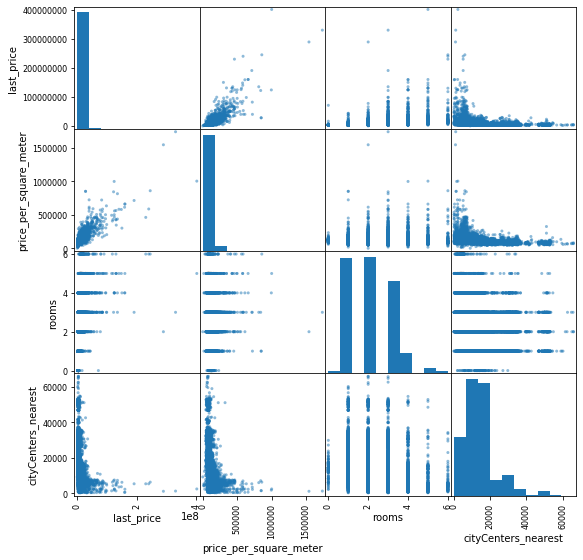

In [16]:
data['price_per_square_meter'] = pd.to_numeric(data['price_per_square_meter'])
data_for_analysis_price = data.loc[:,['last_price','price_per_square_meter','rooms','cityCenters_nearest']]
# exclude NaN from the necessary columns for analysis
data_for_analysis_price2 = data_for_analysis_price.query('last_price.notna() and price_per_square_meter.notna() and rooms.notna() and cityCenters_nearest.notna()')
pd.plotting.scatter_matrix(data_for_analysis_price2, figsize=(9, 9))
print(data_for_analysis_price2.corr())

There is a very high direct correlation between the price per square meter and the price of the apartment (0.78). The higher the price per square meter, the higher the total cost of the apartment. There is also a direct correlation between the number of rooms and the price of the apartment(0.38). The increase in the number of rooms leads to an increase in the overall price of the apartment. On the contrary, between the remoteness from the center and the price there is a slight inverse relationship (-0.24). The further away from the center, the lower the price.

              floor_filter  last_price
floor_filter       1.00000     0.05472
last_price         0.05472     1.00000


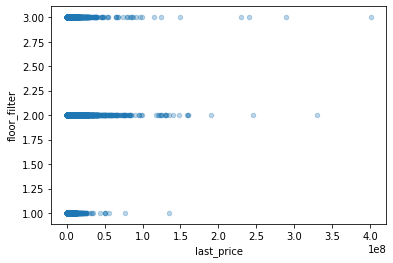

In [17]:
# we assign numerical categories to the floors: 1 "first floor", 2 "floors in the middle of the house", 3 "top floor 
def floor_filter(row):
    if row['floor_category'] == 'первый':
        return 1
    elif row['floor_category'] == 'последний':
        return 3
    else:
        return 2
data['floor_filter'] = data.apply(floor_filter,axis=1)
data_for_analysis_floor = data.loc[:,['floor_filter', 'last_price']]
# exclude NaN from the necessary columns for analysis
data_for_analysis_floor.query('last_price.notna() and floor_filter.notna()')    
data_for_analysis_floor.plot(x='last_price', y='floor_filter', kind='scatter', alpha=0.3)
print(data_for_analysis_floor.corr())

There is a weak, almost nonexistent correlation between the height of the floor and the cost of the apartment. The height of the apartment in the house does not change the price  

            last_price   weekday     month      year
last_price    1.000000  0.002672 -0.004778 -0.051404
weekday       0.002672  1.000000  0.011405 -0.004730
month        -0.004778  0.011405  1.000000 -0.270001
year         -0.051404 -0.004730 -0.270001  1.000000


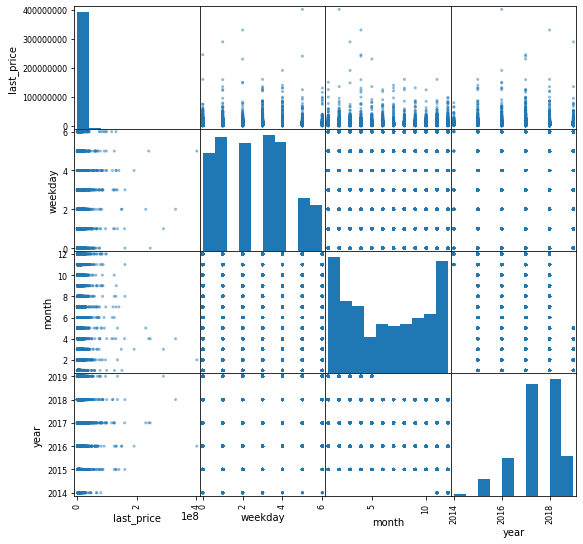

In [18]:
data_for_analysis_date = data.loc[:,['last_price','weekday','month','year']]
pd.plotting.scatter_matrix(data_for_analysis_date, figsize=(9, 9))
print(data_for_analysis_date.corr())

There is no correlation between the date of placement and the price. 

In [19]:
data['price_per_square_meter'] = pd.to_numeric(data['price_per_square_meter'])
print(data.pivot_table(index='locality_name',values='price_per_square_meter',aggfunc=['count','median'])
      .sort_values(by=('count','price_per_square_meter'),ascending=False).head(10))

                                   count                 median
                  price_per_square_meter price_per_square_meter
locality_name                                                  
Санкт-Петербург                    15608            104761.9000
посёлок Мурино                       520             85878.4625
посёлок Шушары                       440             76876.1725
Всеволожск                           398             65789.4740
Пушкин                               368             99993.5895
Колпино                              337             74722.2220
посёлок Парголово                    326             91780.2240
Гатчина                              306             67860.5690
деревня Кудрово                      299             91860.4650
Выборг                               237             58158.3200


Having studied the ten localities with the largest number of advertisements, we see that St. Petersburg has the highest average price per square meter (about 105,000 rubles). After St. Petersburg is Pushkin (about 100,000 rubles) and after Pargolovo and Kudrovo (92,000 rubles). Such a high price is due to the close proximity to St. Petersburg. On the contrary, in the town of Vyborg, which is far from St. Petersburg price per square meter is the lowest (about 58,000 rubles). 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


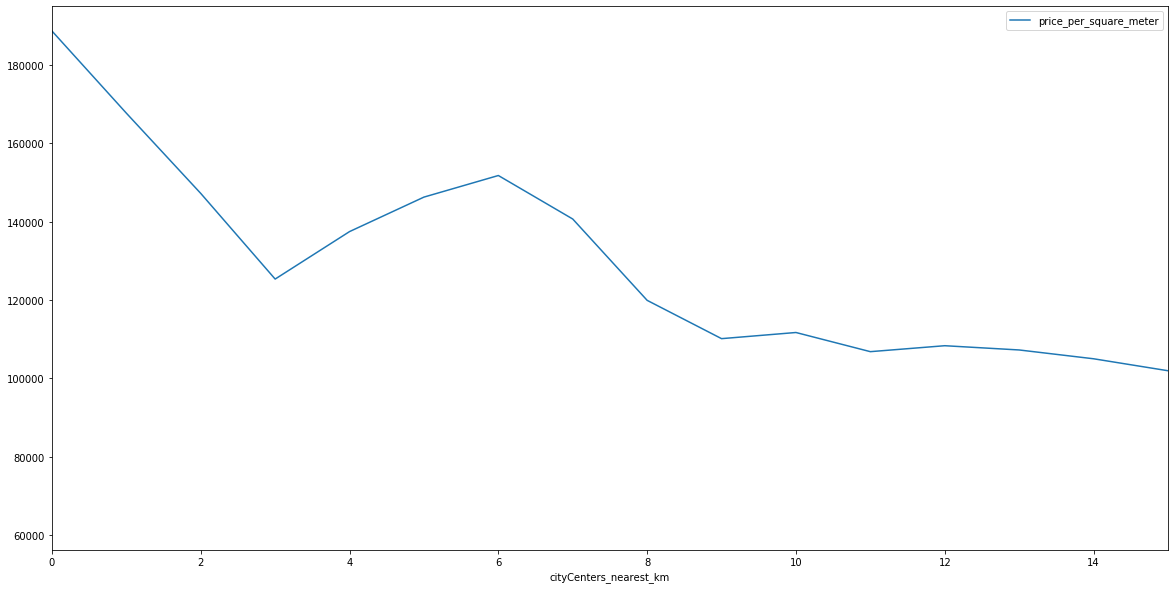

In [20]:
# we sample only St. Petersburg and exclude NaN from the cityCenters_nearest column
data_spb = data.query('locality_name == "Санкт-Петербург" & cityCenters_nearest.notna()')
# create a column for the distance from the center in kilometers
data_spb['cityCenters_nearest_km'] = (data_spb['cityCenters_nearest'] / 1000).astype('int')
data_spb.pivot_table(index='cityCenters_nearest_km',values='price_per_square_meter').plot(figsize=(20,10),xlim=(0,15))

By constructing a graph of the average price per square meter for each kilometer from the center of the city of St. Petersburg, we see that after the third kilometer the price drops sharply. This means that the central area can be considered the territory of the city center up to three kilometers from the center. 

In [21]:
# we sample only St. Petersburg
print(data_spb.loc[:,['last_price','total_area','rooms','ceiling_height']].describe())

         last_price    total_area         rooms  ceiling_height
count  1.554900e+04  15549.000000  15549.000000      9984.00000
mean   7.771333e+06     63.457445      2.138594         2.75794
std    1.021426e+07     35.630954      1.049898         0.28766
min    1.219000e+04     12.000000      0.000000         2.00000
25%    4.200000e+06     41.800000      1.000000         2.55000
50%    5.500000e+06     55.000000      2.000000         2.70000
75%    8.000000e+06     74.000000      3.000000         2.85000
max    4.013000e+08    507.000000      6.000000         4.90000


In [22]:
# we sample only the central area of St. Petersburg
spb_center_analysis = data_spb.query('cityCenters_nearest_km<=3')
print(spb_center_analysis.loc[:,['last_price','total_area','rooms','ceiling_height']].describe())

         last_price   total_area        rooms  ceiling_height
count  1.121000e+03  1121.000000  1121.000000      768.000000
mean   1.480157e+07    93.086744     2.963426        3.188633
std    2.406047e+07    47.299037     1.252676        0.356646
min    2.100000e+06    12.000000     0.000000        2.450000
25%    6.980000e+06    62.000000     2.000000        3.000000
50%    9.350000e+06    83.000000     3.000000        3.150000
75%    1.395000e+07   112.200000     4.000000        3.400000
max    4.013000e+08   401.000000     6.000000        4.900000


In the central zone of St. Petersburg, on average, three-bedroom apartments are sold, which is different from the rest of the city, where two-bedroom apartments predominate. Also, the average ceiling height in the central zone is slightly higher than in the rest of the city (the average ceiling in the center is higher by 44 cm). Also, the total area of housing in the center exceeds the same figure for the entire city (93 sq.m. vs. 64 sq.m.). We can conclude that the central area offers more respectable options for apartments. 

                     last_price     floor     rooms  cityCenters_nearest
last_price             1.000000 -0.007758  0.377617            -0.297533
floor                 -0.007758  1.000000 -0.163670             0.226665
rooms                  0.377617 -0.163670  1.000000            -0.281753
cityCenters_nearest   -0.297533  0.226665 -0.281753             1.000000


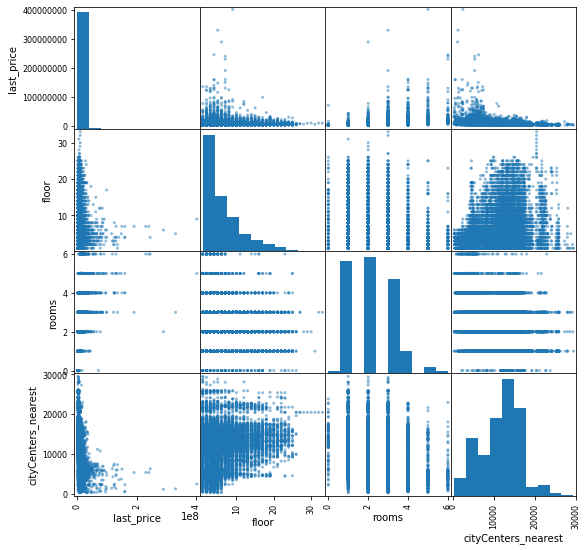

In [23]:
# we sample only St. Petersburg
spb_center_analysis = data_spb.loc[:,['last_price','floor','rooms','cityCenters_nearest','first_day_exposition']]
pd.plotting.scatter_matrix(spb_center_analysis, figsize=(9, 9))
print(spb_center_analysis.corr())

There is no correlation between the floor and the price of the apartment throughout St. Petersburg. In this case, the more rooms in the apartment, the higher the price for it. This is a direct correlation (level of correlation = 0.38). On the contrary, there is an inverse dependence between the remoteness from the center and the apartment price (-0.3). The farther the apartment is from the center, the cheaper it is

                     last_price     floor     rooms  cityCenters_nearest
last_price             1.000000  0.201078  0.240192            -0.168016
floor                  0.201078  1.000000  0.131246             0.082164
rooms                  0.240192  0.131246  1.000000            -0.057245
cityCenters_nearest   -0.168016  0.082164 -0.057245             1.000000


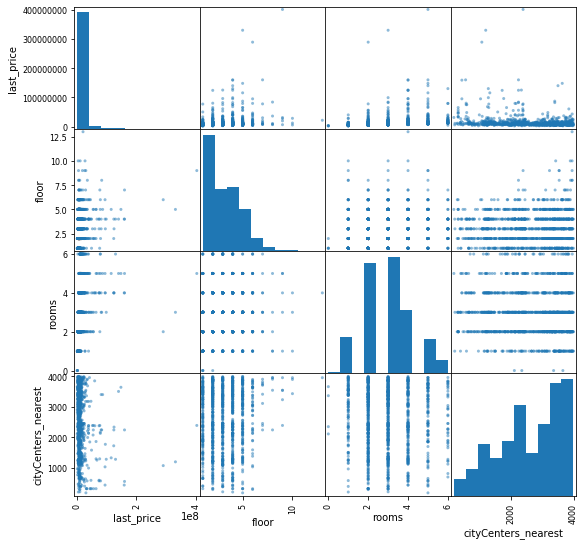

In [24]:
# we sample only the central area of St. Petersburg
data2 = data_spb.query('cityCenters_nearest_km<=3')
# print(data2['locality_name'].value_counts())
spb_center_analysis = data2.loc[:,['last_price','floor','rooms','cityCenters_nearest','first_day_exposition']]
pd.plotting.scatter_matrix(spb_center_analysis, figsize=(9, 9))
print(spb_center_analysis.corr())

In contrast to the rest of the city, there is no correlation between location in the city center and cost of housing in the central zone. There is also a direct dependence on the number of rooms and the price, but the correlation index is slightly lower than throughout the city (0.24 vs. 0.38). The floor also has a greater influence on the price of the apartment in the central zone (0.24) than in the whole city (0.01)  

### Step 5: General conclusion

We investigated the archive of announcements about apartments for sale in St. Petersburg and neighboring localities for several years. Having identified and studied the missing values, we formed a general idea about the market of advertisements. 
So the median price per square meter is about 95.000 rubles. 
Also the median value for time of sale of the apartment - about three months (95 days) Two months is already a fast transaction, less than a month and a half - very fast. On the contrary, more than seven months is already unusually long to sell an apartment.
After studying the ten cities with the largest number of ads, we see that in St. Petersburg has the highest average price per square meter (about 105,000 rubles). After St. Petersburg is Pushkin (about 100,000 rubles) and after Pargolovo and Kudrovo (92,000 rubles). Such a high price is due to the close proximity to St. Petersburg. On the contrary, in the town of Vyborg, which is far from St. Petersburg the price per square meter is the lowest (about 58,000 rubles).
By constructing a graph of the average price per square meter for each kilometer from the center of St. Petersburg, we see that after the third kilometer the price drops sharply. This means that the central area can be considered the territory of the city center to three kilometers from the center. 